In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from skimage.io import imread
from skimage.color import rgb2hed, rgba2rgb
import os
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from scipy.stats import randint, loguniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import time
from tqdm import tqdm
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset

In [ ]:
image_folder = "/Users/bella/Desktop/patches_256/"  # Tissue Images 
csv_file    = "/Users/bella/Desktop/protein_expression_data.csv" 

df = pd.read_csv("/Users/bella/Desktop/protein_expression_data.csv")

df['specimen_id']=df.VisSpot.apply(lambda x: x.split('-')[2]) #create specimen id field
df['image_id']=df.VisSpot.apply(lambda x: x.split('-')[2])+'_'+df.id #create image id field
df = df.set_index('image_id').sort_index()
protein_names = ['SMAa', 'CD11b',
       'CD44', 'CD31', 'CDK4', 'YKL40', 'CD11c', 'HIF1a', 'CD24', 'TMEM119',
       'OLIG2', 'GFAP', 'VISTA', 'IBA1', 'CD206', 'PTEN', 'NESTIN', 'TCIRG1',
       'CD74', 'MET', 'P2RY12', 'CD163', 'S100B', 'cMYC', 'pERK', 'EGFR',
       'SOX2', 'HLADR', 'PDGFRa', 'MCT4', 'DNA1', 'DNA3', 'MHCI', 'CD68',
       'CD14', 'KI67', 'CD16', 'SOX10']

all_png_files = [
    f for f in os.listdir(image_folder) if f.lower().endswith(".png")
]
training_images = [
    os.path.join(image_folder, f)
    for f in all_png_files
    if ("B1" in f or "C1" in f or "D1" in f)
]
testing_images = [
    os.path.join(image_folder, f)
    for f in all_png_files
    if "A1" in f
]
test_data  = df[df["specimen_id"] == "A1"]
# Seperating A1 in the protien expression file
train_data = df[df['specimen_id'].isin(['B1', 'C1', 'D1'])]

specimen_id
C1    4129
D1    1753
B1    1145
Name: count, dtype: int64


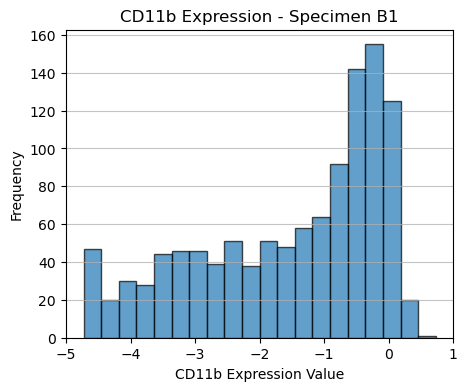

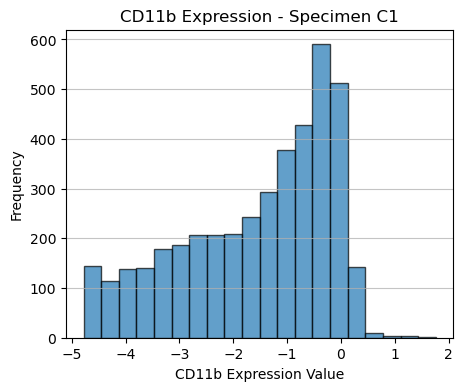

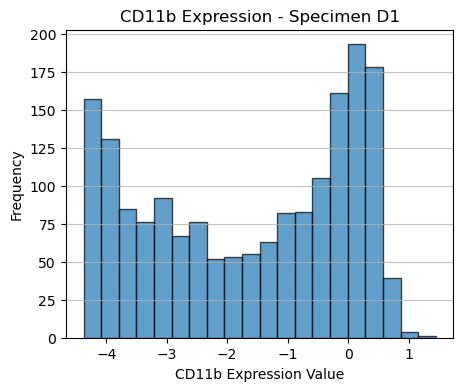

In [3]:
print(train_data['specimen_id'].value_counts())

# Histograms for each specimen 
specimens = ['B1', 'C1', 'D1']
for specimen in specimens:
    subset = train_data[train_data['specimen_id'] == specimen]
    
    plt.figure(figsize=(5, 4))
    plt.hist(subset['CD11b'], bins=20, edgecolor='black', alpha=0.7)
    plt.title(f'CD11b Expression - Specimen {specimen}')
    plt.xlabel('CD11b Expression Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

From the training set, the total number of spots/examples in each is:
- **C1**: 4129 spots  
- **D1**: 1753 spots  
- **B1**: 1145 spots  


- **Specimen B1**:  
  - CD11b expression ranges roughly from about –5 up to 1.  
  - The distribution is somewhat skewed, with a single main peak around –1 to 0 and fewer extreme values in the tails.  

- **Specimen C1**:  
  - Spreads from about –5 up to 2, again peaking near –1 to 0.  
  - With many more total spots (4129), the histogram shows a large concentration around –1, tapering off toward more positive values; only a small fraction extends above 1.  

- **Specimen D1**:  
  - Ranges from about –4.5 up to 1+; appears to have more then one peak. One cluster is around –3.5 to –2, and another is around –1 to 0, with a notable dip between those peaks.  

Overall, **B1** and **C1** show fairly single-peak distributions centered near negative values, whereas **D1** hints at two possible modes for CD11b expression. All three have long tails at the extremes, suggesting that a small number of spots have either relatively low or relatively high expression compared to the bulk of the distribution.

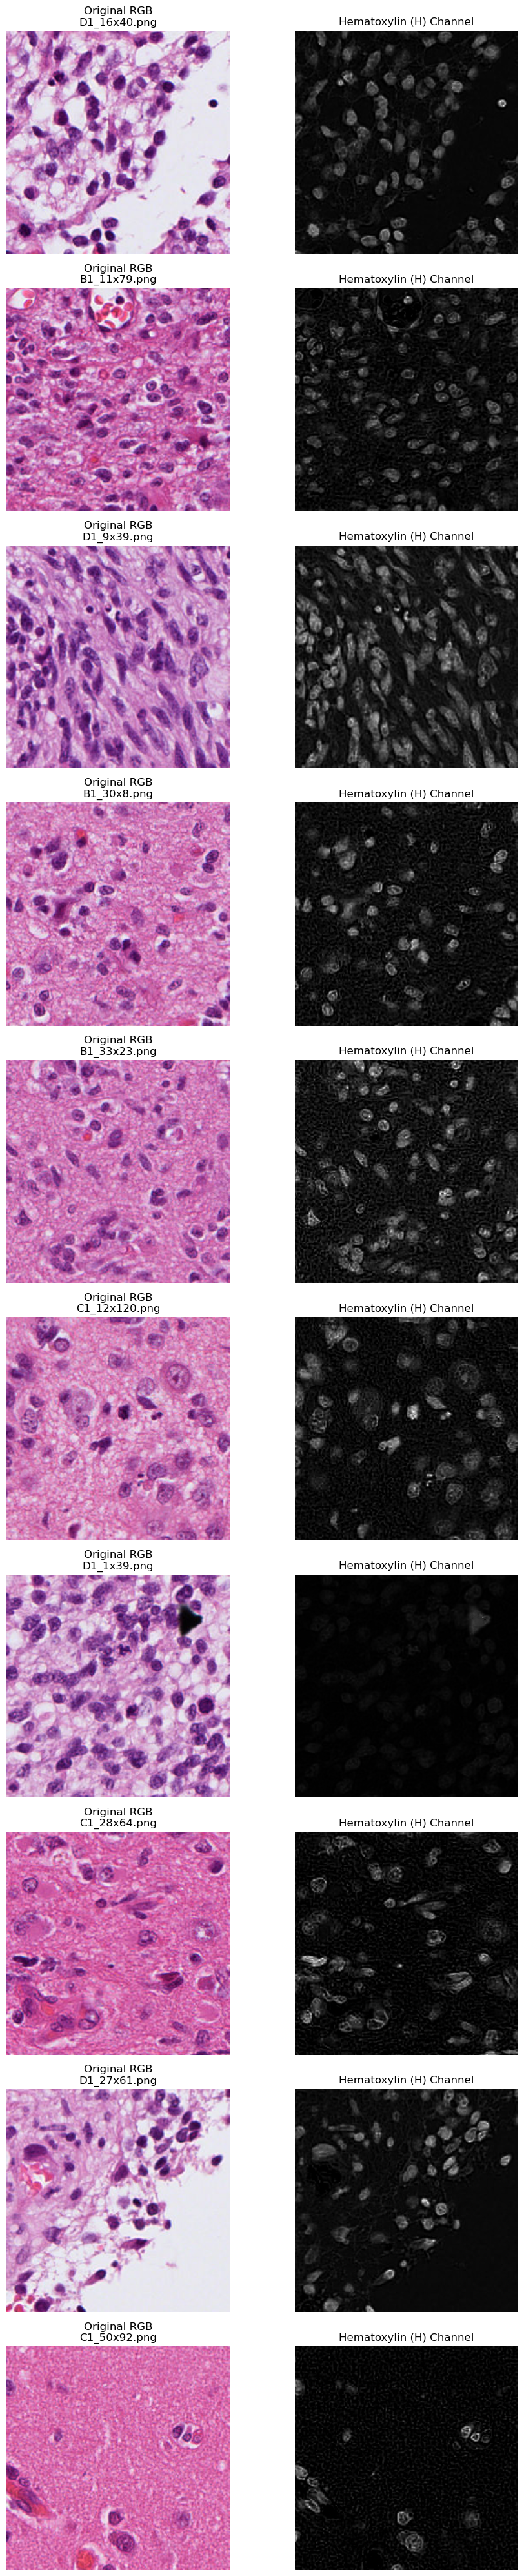

In [4]:
# Randomly select 10 files as a selection
sample_files = random.sample(training_images, 10)

fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 4*10))

for i, path in enumerate(sample_files):
    # Some of the images have extra channel
    img_rgba = imread(path)
    
    if img_rgba.shape[-1] == 4:
        img_rgb = rgba2rgb(img_rgba)
    else:
        img_rgb = img_rgba
    
    # Convert the RGB image to HED space
    img_hed = rgb2hed(img_rgb)
    h_channel = img_hed[..., 0]

    # Original image
    axes[i, 0].imshow(img_rgb)
    axes[i, 0].set_title(f"Original RGB\n{os.path.basename(path)}")
    axes[i, 0].axis('off')
    
    # H-Channel
    im_h = axes[i, 1].imshow(h_channel, cmap='gray')
    axes[i, 1].set_title("Hematoxylin (H) Channel")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

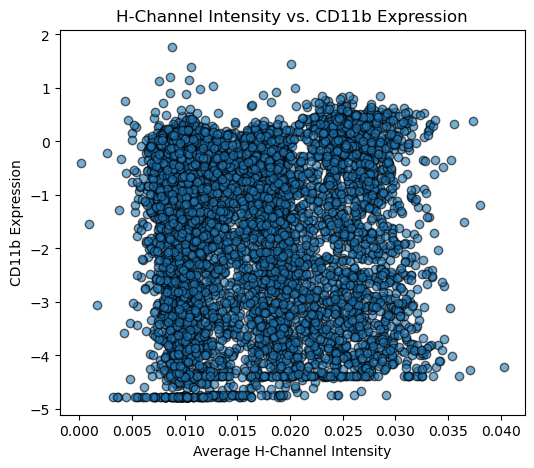

Correlation (H vs. CD11b): -0.073


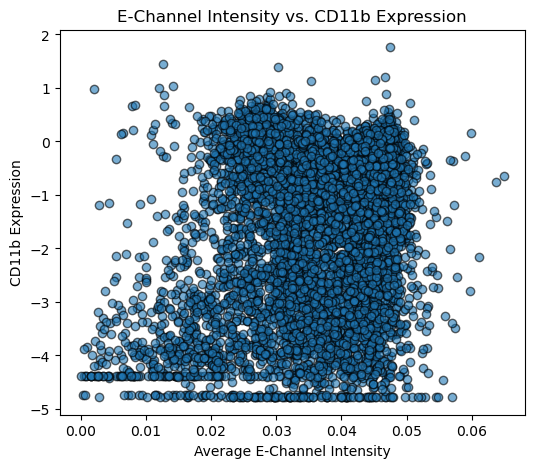

Correlation (E vs. CD11b): 0.278


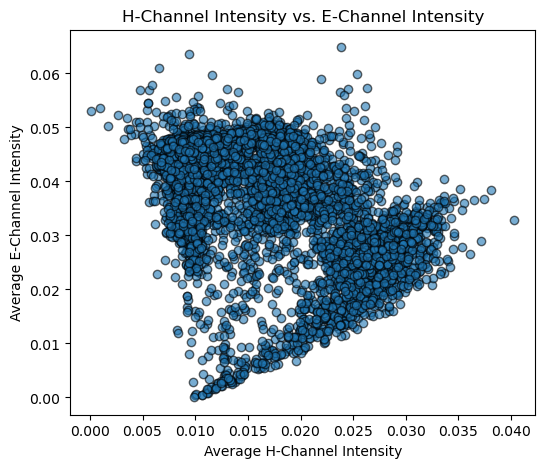

Correlation (H vs. E): -0.519


In [ ]:
# Lists to store average H/E-channel and CD11b expression
h_averages = []
e_averages = []
cd11b_values = []

for path in training_images:
    filename = os.path.basename(path)
    image_id = os.path.splitext(filename)[0] # Just the identifier 

    # Read the image
    img_rgba = imread(path)
    # Convert RGBA to RGB if needed
    if img_rgba.shape[-1] == 4:
        img_rgb = rgba2rgb(img_rgba)
    else:
        img_rgb = img_rgba
    
    # Convert from RGB to HED
    img_hed = rgb2hed(img_rgb)
    
    # Extract the Hematoxylin (H) channel and Eosin (E) channel
    h_channel = img_hed[..., 0]
    e_channel = img_hed[..., 1]
    
    # Compute the mean intensity
    h_mean = np.mean(h_channel)
    e_mean = np.mean(e_channel)
    
    if image_id in train_data.index:
        # Retrieve the CD11b expression value for this image
        cd11b_expr = train_data.loc[image_id, 'CD11b']
        
        h_averages.append(h_mean)
        e_averages.append(e_mean)
        cd11b_values.append(cd11b_expr)

plt.figure(figsize=(6, 5))
plt.scatter(h_averages, cd11b_values, alpha=0.6, edgecolor='k')
plt.xlabel('Average H-Channel Intensity')
plt.ylabel('CD11b Expression')
plt.title('H-Channel Intensity vs. CD11b Expression')
plt.show()

corr_h = np.corrcoef(h_averages, cd11b_values)[0, 1]
print(f"Correlation (H vs. CD11b): {corr_h:.3f}")

plt.figure(figsize=(6, 5))
plt.scatter(e_averages, cd11b_values, alpha=0.6, edgecolor='k')
plt.xlabel('Average E-Channel Intensity')
plt.ylabel('CD11b Expression')
plt.title('E-Channel Intensity vs. CD11b Expression')
plt.show()

corr_e = np.corrcoef(e_averages, cd11b_values)[0, 1]
print(f"Correlation (E vs. CD11b): {corr_e:.3f}")

plt.figure(figsize=(6, 5))
plt.scatter(h_averages, e_averages, alpha=0.6, edgecolor='k')
plt.xlabel('Average H-Channel Intensity')
plt.ylabel('Average E-Channel Intensity')
plt.title('H-Channel Intensity vs. E-Channel Intensity')
plt.show()

corr_h = np.corrcoef(h_averages, e_averages)[0, 1]
print(f"Correlation (H vs. E): {corr_h:.3f}")


- H vs. CD11b ($r \approx -0.073$): Shows no significant linear relationship; simply averaging the Haematoxylin channel intensity provides little predictive value for CD11b.
- E vs. CD11b ($r \approx +0.278$): A mild positive correlation, indicating some predictive signal in the Eosin channel, though still limited.
- H vs. E ($r \approx -0.519$): A moderate negative relationship, typical of H&E staining.

Averaging H/E intensities alone offers only some insight into CD11b levels, more advanced approached would be required for robust CD11b prediction.


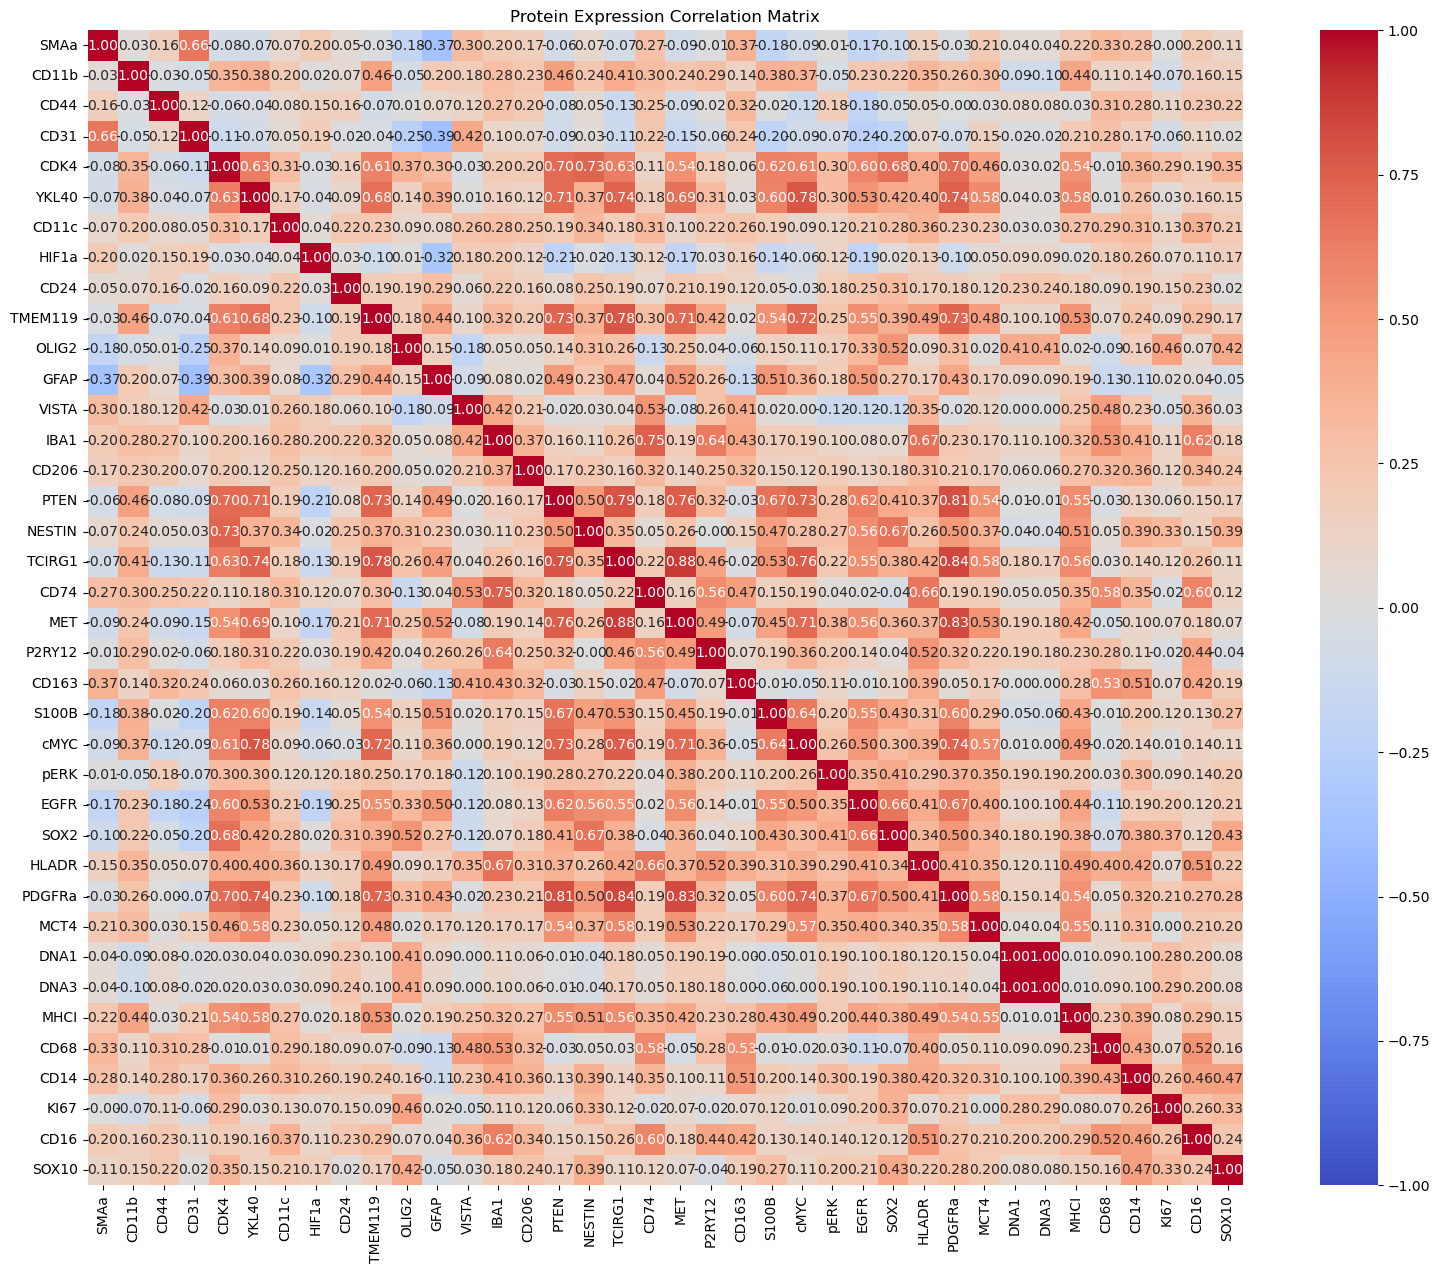

In [9]:
protein_cols = ['SMAa', 'CD11b',
       'CD44', 'CD31', 'CDK4', 'YKL40', 'CD11c', 'HIF1a', 'CD24', 'TMEM119',
       'OLIG2', 'GFAP', 'VISTA', 'IBA1', 'CD206', 'PTEN', 'NESTIN', 'TCIRG1',
       'CD74', 'MET', 'P2RY12', 'CD163', 'S100B', 'cMYC', 'pERK', 'EGFR',
       'SOX2', 'HLADR', 'PDGFRa', 'MCT4', 'DNA1', 'DNA3', 'MHCI', 'CD68',
       'CD14', 'KI67', 'CD16', 'SOX10']  # or whatever set you want

# Correlation matrix
corr_matrix = train_data[protein_cols].corr(method='pearson')
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f",
            vmin=-1, vmax=1, square=True)
plt.title('Protein Expression Correlation Matrix')
plt.show()

The correlation heatmap provides a clear visual summary of protein expression relationships, each cell contains the Pearson’s *r* value, which quantifies the linear relationship:  

- **+1** being strong positive correlation.  
- **−1** being strong negative correlation.  
- **0** being minimal linear dependence.  

By examining the heatmap, we can identify clusters of co-expressed proteins offering insight into how protein expression levels are related.


I loop through each image and compute the mean and variance for both **RGB** channels and **HED** channels, and store them (along with the CD11b label) in a dataframe. 

Beyond computing the mean and variance, I also flatten each image’s raw pixels and apply a kernel approximation to extract richer relationships among pixels than a simple linear method would.

In [11]:
# Create a list/dict to store features
feature_rows = []  # will become a list of dicts

for path in training_images:
    filename = os.path.basename(path)
    image_id = os.path.splitext(filename)[0]

    if image_id not in train_data.index:
        continue  # skip if image doesn't have representation 

    img_rgba = imread(path)
    if img_rgba.shape[-1] == 4: 
        img_rgb = rgba2rgb(img_rgba)
    else:
        img_rgb = img_rgba

    img_rgb = img_rgb.astype(np.float32)

    # Each channel: 0=R, 1=G, 2=B
    R_channel = img_rgb[..., 0]
    G_channel = img_rgb[..., 1]
    B_channel = img_rgb[..., 2]

    R_mean, R_var = np.mean(R_channel), np.var(R_channel)
    G_mean, G_var = np.mean(G_channel), np.var(G_channel)
    B_mean, B_var = np.mean(B_channel), np.var(B_channel)

    img_hed = rgb2hed(img_rgb)
    H_channel = img_hed[..., 0]
    E_channel = img_hed[..., 1]
    D_channel = img_hed[..., 2]

    H_mean, H_var = np.mean(H_channel), np.var(H_channel)
    E_mean, E_var = np.mean(E_channel), np.var(E_channel)
    D_mean, D_var = np.mean(D_channel), np.var(D_channel)

    features = {
        'image_id': image_id,
        'R_mean': R_mean, 'R_var': R_var,
        'G_mean': G_mean, 'G_var': G_var,
        'B_mean': B_mean, 'B_var': B_var,
        'H_mean': H_mean, 'H_var': H_var,
        'E_mean': E_mean, 'E_var': E_var,
        'D_mean': D_mean, 'D_var': D_var,

        'CD11b': train_data.loc[image_id, 'CD11b']  # target variable
    }
    feature_rows.append(features)

features_df = pd.DataFrame(feature_rows)
features_df.set_index('image_id', inplace=True)
print("Train/Validate features from specimen B/C/D:")
display(features_df)

# Features from the test set (later will be used for testing)
feature_rows_test = []

for path in testing_images:
    filename = os.path.basename(path)            
    image_id = os.path.splitext(filename)[0]     
    
    if image_id not in df.index:
        continue

    # Read image
    img_rgba = imread(path)
    # Convert RGBA->RGB if needed
    if img_rgba.shape[-1] == 4:
        img_rgb = rgba2rgb(img_rgba)
    else:
        img_rgb = img_rgba

    img_rgb = img_rgb.astype(np.float32)

    R_channel = img_rgb[..., 0]
    G_channel = img_rgb[..., 1]
    B_channel = img_rgb[..., 2]

    R_mean, R_var = np.mean(R_channel), np.var(R_channel)
    G_mean, G_var = np.mean(G_channel), np.var(G_channel)
    B_mean, B_var = np.mean(B_channel), np.var(B_channel)

    img_hed = rgb2hed(img_rgb)
    H_channel = img_hed[..., 0]
    E_channel = img_hed[..., 1]
    D_channel = img_hed[..., 2]

    H_mean, H_var = np.mean(H_channel), np.var(H_channel)
    E_mean, E_var = np.mean(E_channel), np.var(E_channel)
    D_mean, D_var = np.mean(D_channel), np.var(D_channel)

    cd11b_val = df.loc[image_id, 'CD11b'] 

    feature_dict = {
        'image_id': image_id,
        'R_mean': R_mean, 'R_var': R_var,
        'G_mean': G_mean, 'G_var': G_var,
        'B_mean': B_mean, 'B_var': B_var,
        'H_mean': H_mean, 'H_var': H_var,
        'E_mean': E_mean, 'E_var': E_var,
        'D_mean': D_mean, 'D_var': D_var,
        'CD11b': cd11b_val  
    }
    feature_rows_test.append(feature_dict)

test_features_df = pd.DataFrame(feature_rows_test)
test_features_df.set_index('image_id', inplace=True)
print("Test features from specimen A:")
display(test_features_df)

Train/Validate features from specimen B/C/D:


R_mean        R_var      G_mean        G_var      B_mean  \
image_id                                                                 
C1_46x86  205.911346   767.405518  102.633392   836.078918  168.557861   
C1_69x65  211.242523   648.958496  114.663681  1004.022644  177.928680   
C1_6x116  199.572662   896.172729  122.960068  1467.999878  179.039261   
D1_36x62  199.409286  2041.148804  163.555832  4191.192383  201.800934   
D1_19x81  188.936615  1511.607666  129.665024  2086.697754  186.707809   
...              ...          ...         ...          ...         ...   
C1_60x58  204.518463   853.586182  103.007645  1068.821045  169.208344   
C1_67x51  207.099976   707.509521  105.859497   820.916748  172.061996   
D1_38x56  191.405075  1924.730713  146.094803  3539.655518  192.720108   
D1_9x53   192.874390  1688.035400  141.279617  3318.793213  190.645355   
C1_35x71  206.290100   727.222046  106.283554  1026.856812  170.980972   

                B_var  H_mean  H_var    E_mean     E_var  D_mean  D_var  \
image_id                                                                  
C1_46x86   507.693329     0.0    0.0  0.189203  0.000190     0.0    0.0   
C1_69x65   528.713562     0.0    0.0  0.183635  0.000171     0.0    0.0   
C1_6x116   745.588440     0.0    0.0  0.175087  0.000264     0.0    0.0   
D1_36x62  1755.049561     0.0    0.0  0.159504  0.000486     0.0    0.0   
D1_19x81   965.599304     0.0    0.0  0.169009  0.000301     0.0    0.0   
...               ...     ...    ...       ...       ...     ...    ...   
C1_60x58   635.055725     0.0    0.0  0.189079  0.000228     0.0    0.0   
C1_67x51   465.466980     0.0    0.0  0.187400  0.000155     0.0    0.0   
D1_38x56  1528.800537     0.0    0.0  0.164021  0.000451     0.0    0.0   
D1_9x53   1403.209229     0.0    0.0  0.166586  0.000472     0.0    0.0   
C1_35x71   566.492065     0.0    0.0  0.187263  0.000225     0.0    0.0   

             CD11b  
image_id            
C1_46x86 -0.460926  
C1_69x65 -0.747339  
C1_6x116 -2.675553  
D1_36x62 -3.228205  
D1_19x81  0.150012  
...            ...  
C1_60x58  0.216007  
C1_67x51  0.120310  
D1_38x56 -1.584396  
D1_9x53  -3.608243  
C1_35x71 -0.223485  

[7027 rows x 13 columns]

Test features from specimen A:


R_mean     R_var    G_mean     G_var    B_mean     B_var  \
image_id                                                                
A1_59x73   0.810137  0.010062  0.433641  0.013388  0.676688  0.006848   
A1_71x101  0.783641  0.017767  0.493482  0.033611  0.711760  0.015155   
A1_71x99   0.774045  0.016355  0.475510  0.028982  0.704223  0.012997   
A1_61x101  0.796203  0.013260  0.413434  0.016961  0.664699  0.008710   
A1_44x36   0.824234  0.012620  0.474052  0.039162  0.668382  0.024824   
...             ...       ...       ...       ...       ...       ...   
A1_50x66   0.799643  0.012627  0.427360  0.020461  0.670513  0.009646   
A1_50x72   0.805885  0.013781  0.443878  0.023871  0.679054  0.011401   
A1_57x53   0.791277  0.012808  0.442868  0.017304  0.683263  0.008319   
A1_18x36   0.807183  0.014674  0.580184  0.043973  0.750775  0.019441   
A1_57x47   0.780091  0.014243  0.494776  0.030603  0.715326  0.012866   

             H_mean     H_var    E_mean     E_var    D_mean     D_var  \
image_id                                                                
A1_59x73   0.009373  0.000176  0.042198  0.000167  0.027934  0.000068   
A1_71x101  0.016701  0.000392  0.033628  0.000348  0.022277  0.000119   
A1_71x99   0.017551  0.000355  0.034868  0.000298  0.022522  0.000099   
A1_61x101  0.010957  0.000248  0.045374  0.000236  0.028780  0.000077   
A1_44x36   0.008675  0.000213  0.039103  0.000511  0.033033  0.000545   
...             ...       ...       ...       ...       ...       ...   
A1_50x66   0.011162  0.000210  0.043294  0.000251  0.028401  0.000101   
A1_50x72   0.010795  0.000212  0.041832  0.000292  0.027741  0.000116   
A1_57x53   0.013030  0.000255  0.039638  0.000221  0.026047  0.000078   
A1_18x36   0.014933  0.000249  0.024955  0.000421  0.019538  0.000186   
A1_57x47   0.017063  0.000293  0.032607  0.000307  0.021513  0.000108   

              CD11b  
image_id             
A1_59x73   0.795192  
A1_71x101 -1.086760  
A1_71x99   0.475199  
A1_61x101  0.493615  
A1_44x36   0.822605  
...             ...  
A1_50x66   0.205205  
A1_50x72  -1.239739  
A1_57x53   0.820699  
A1_18x36  -2.013253  
A1_57x47   1.396705  

[2894 rows x 13 columns]

### Most Appropriate Metric 
For a continuous target like CD11b expression (which we want to predict on its original numeric scale), RMSE (Root Mean Squared Error) is typically the most appropriate metric. It directly measures the average magnitude of prediction errors in the same units as the target, penalising large deviations more heavily.  

While R², Pearson, and Spearman are also helpful, especially for understanding correlation or proportion of variance explained—RMSE is best for assessing how close the predictions are to the actual expression values. It gives a clear, interpretable sense of how large the typical prediction error is in the original CD11b scale.  

### OLS & XGBoost
In this code, I take the numeric features (mean/variance from RGB and HED channels) for each image and train two regression models (Ordinary Least Squares and XGBoost) to predict CD11b expression. I split the data into training/validation, tune hyperparameters for XGBoost, then evaluate both models on the validation and test sets. Finally, I display metrics (RMSE, Pearson, Spearman, R²) in tables and produce scatter plots of true vs. predicted values.  

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best hyperparameters found:
{'learning_rate': 0.01868241928427023, 'max_depth': 31, 'n_estimators': 107}

=== Validation Set Performance ===


Model    RMSE      R2  Pearson  Spearman
0      OLS  1.3291  0.2091   0.4623    0.4971
1  XGBoost  1.1925  0.3634   0.6057    0.6167

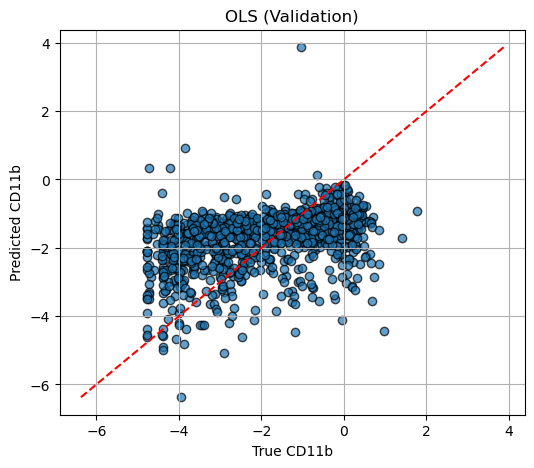

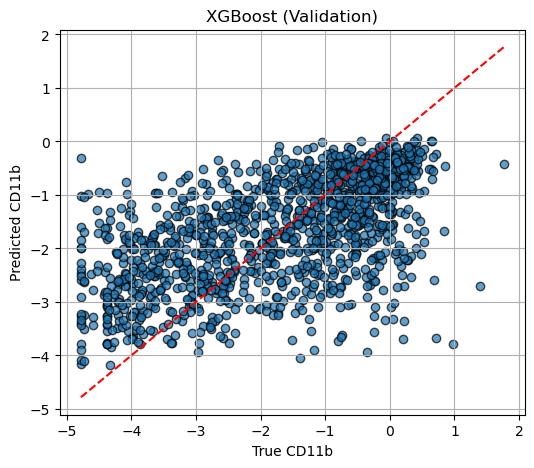


=== Test Set Performance (Specimen A1) ===


Model    RMSE      R2  Pearson  Spearman
0      OLS  1.7596 -0.5012   0.4292    0.5136
1  XGBoost  1.3827  0.0731   0.3948    0.3961

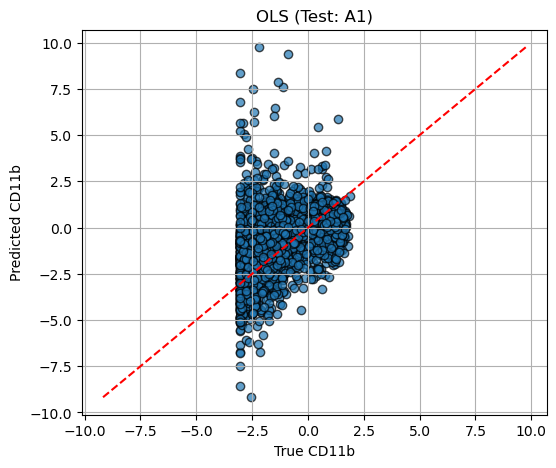

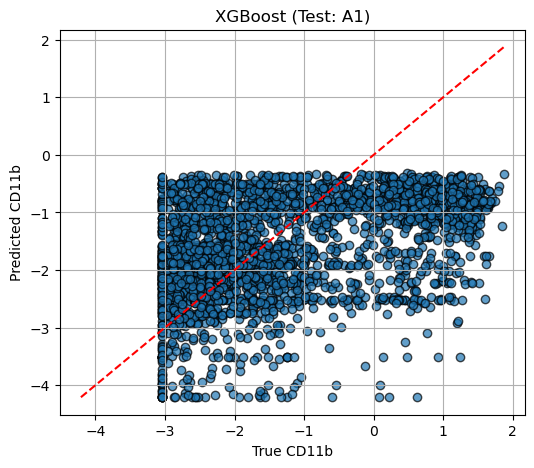

In [13]:
feature_cols = [
    "R_mean", "R_var", "G_mean", "G_var",
    "B_mean", "B_var", "H_mean", "H_var",
    "E_mean", "E_var", "D_mean", "D_var"
]

X_all = features_df[feature_cols].values
y_all = features_df["CD11b"].values

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2
)

# OLS MODEL 
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)
y_pred_val_ols = ols_model.predict(X_val)

# XGBoost Hyperparameter Tuning
param_distributions = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(30, 60),
    'learning_rate': loguniform(1e-4, 0.1)
}

xgb_base = XGBRegressor(tree_method='hist')  
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1,
)
random_search.fit(X_train, y_train)
print("Best hyperparameters found:")
print(random_search.best_params_)

best_xgb = random_search.best_estimator_
y_pred_val_xgb = best_xgb.predict(X_val)

def compute_metrics(y_true, y_pred):         # Metrics Displayed
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    pear, _ = pearsonr(y_true, y_pred)
    spear, _ = spearmanr(y_true, y_pred)
    return rmse, r2, pear, spear

metrics_val_ols  = compute_metrics(y_val, y_pred_val_ols)
metrics_val_xgb  = compute_metrics(y_val, y_pred_val_xgb)

val_table = pd.DataFrame({
    'Model':     ['OLS',               'XGBoost'],
    'RMSE':      [metrics_val_ols[0],  metrics_val_xgb[0]],
    'R2':        [metrics_val_ols[1],  metrics_val_xgb[1]],
    'Pearson':   [metrics_val_ols[2],  metrics_val_xgb[2]],
    'Spearman':  [metrics_val_ols[3],  metrics_val_xgb[3]],
}).round(4)

print("\n=== Validation Set Performance ===")
display(val_table)

def scatter_pred_vs_true(y_true, y_pred, title=""):
    plt.figure(figsize=(6,5))
    plt.scatter(y_true, y_pred, alpha=0.7, edgecolor='k')
    plt.xlabel("True CD11b")
    plt.ylabel("Predicted CD11b")
    plt.title(title)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.grid(True)
    plt.show()

scatter_pred_vs_true(y_val, y_pred_val_ols,  "OLS (Validation)")
scatter_pred_vs_true(y_val, y_pred_val_xgb,  "XGBoost (Validation)")

X_test = test_features_df[feature_cols].values  # Test set
y_test = test_features_df["CD11b"].values

y_pred_test_ols = ols_model.predict(X_test)
y_pred_test_xgb = best_xgb.predict(X_test)

metrics_test_ols = compute_metrics(y_test, y_pred_test_ols)
metrics_test_xgb = compute_metrics(y_test, y_pred_test_xgb)

test_table = pd.DataFrame({
    'Model':     ['OLS',               'XGBoost'],
    'RMSE':      [metrics_test_ols[0], metrics_test_xgb[0]],
    'R2':        [metrics_test_ols[1], metrics_test_xgb[1]],
    'Pearson':   [metrics_test_ols[2], metrics_test_xgb[2]],
    'Spearman':  [metrics_test_ols[3], metrics_test_xgb[3]],
}).round(4)

print("\n=== Test Set Performance (Specimen A1) ===")
display(test_table)

scatter_pred_vs_true(y_test, y_pred_test_ols, "OLS (Test: A1)")
scatter_pred_vs_true(y_test, y_pred_test_xgb, "XGBoost (Test: A1)")

### Random Forest + RBF Kenral (Nystroem)

This code loads each image (flattening the pixels into a single vector), then applies a Nystroem kernel approximation to map those raw pixel vectors into a nonlinear feature space giving us features. A RandomForestRegressor (with tuned hyperparameters) is trained on the resulting feature vectors (for B1/C1/D1) to predict CD11b expression, and then tested on A1. Finally, it displays a table of metrics (RMSE, R², Pearson, Spearman) for the test set and plots a scatter of true vs. predicted values.


Performance on A1 (Test Set):


RMSE     R^2  Pearson_r  Spearman_rho
Test Set (A1)  1.2625  0.2272     0.5257        0.5345

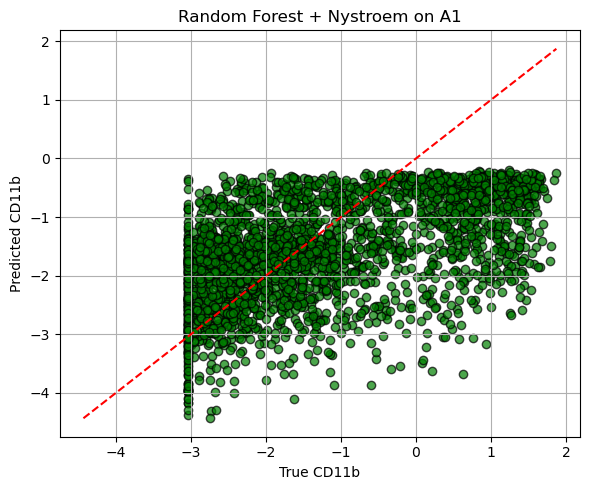

In [ ]:
X_train_list = []
y_train_list = []

for path in training_images:
    filename = os.path.basename(path)
    image_id = os.path.splitext(filename)[0]
    
    if image_id not in train_data.index:
        continue
    
    img_rgba = imread(path)
    if img_rgba.shape[-1] == 4:
        img_rgb = rgba2rgb(img_rgba)
    else:
        img_rgb = img_rgba
    
    img_rgb = img_rgb.astype(np.float32)
    flat_pixels = img_rgb.reshape(-1)
    
    cd11b_value = train_data.loc[image_id, "CD11b"]
    
    X_train_list.append(flat_pixels)
    y_train_list.append(cd11b_value)

X_train_raw = np.array(X_train_list)
y_train = np.array(y_train_list)

X_test_list = []
y_test_list = []

for path in testing_images:
    filename = os.path.basename(path)
    image_id = os.path.splitext(filename)[0]
    
    if image_id not in test_data.index:
        continue
    
    img_rgba = imread(path)
    if img_rgba.shape[-1] == 4:
        img_rgb = rgba2rgb(img_rgba)
    else:
        img_rgb = img_rgba
    
    img_rgb = img_rgb.astype(np.float32)
    flat_pixels = img_rgb.reshape(-1)
    
    cd11b_value = test_data.loc[image_id, "CD11b"]
    
    X_test_list.append(flat_pixels)
    y_test_list.append(cd11b_value)

X_test_raw = np.array(X_test_list)
y_test = np.array(y_test_list)

# Nystroem approx kernel 
n_components_nystroem = 5000
nystroem = Nystroem(
    kernel='rbf',
    gamma=1e-4,
    n_components=n_components_nystroem
)
X_train_ny = nystroem.fit_transform(X_train_raw)
X_test_ny  = nystroem.transform(X_test_raw)

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=40
)
rf.fit(X_train_ny, y_train)

y_pred = rf.predict(X_test_ny)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
pear, _ = pearsonr(y_test, y_pred)
spear, _ = spearmanr(y_test, y_pred)

metrics_df = pd.DataFrame([{
    'RMSE':         round(rmse, 4),
    'R^2':          round(r2, 4),
    'Pearson_r':    round(pear, 4),
    'Spearman_rho': round(spear, 4)
}], index=['Test Set (A1)'])

print("\nPerformance on A1 (Test Set):")
display(metrics_df)

plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k', color='green')
plt.xlabel("True CD11b")
plt.ylabel("Predicted CD11b")
plt.title("Random Forest + Nystroem on A1")

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()

I initially began with the ResNet architecture (pretrained on ImageNet) to predict CD11b , but the performance was low. Therefore, I designed a custom CNN to capture domain‐specific features and achieve better predictive accuracy.

### Resnet18
This code uses a pretrained ResNet18 (with its final layer replaced by a single linear output) to regress the CD11b value from images. After loading the CSV and filtering for valid image paths, it splits the data into train/validation (specimens B1, C1, D1) and a test set (A1). The images are normalised, then fed into ResNet18—with all layers frozen except the final layer. The code tracks training and validation loss, saves the best validation model and finally evaluates on both validation and test sets, reporting RMSE, R², Pearson, Spearman, and showing scatter plots of true vs. predicted CD11b.

Train set: 5621 | Val set: 1406 | Test set: 2894


c:\Users\bella\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bella\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 176/176 [00:31<00:00,  5.58it/s]


Epoch 1/20 | Train MSE: 2.7989, Val MSE: 2.1134 | Epoch time: 38.9s


Epoch 2: 100%|██████████| 176/176 [00:30<00:00,  5.80it/s]


Epoch 2/20 | Train MSE: 2.4123, Val MSE: 1.9194 | Epoch time: 37.5s


Epoch 3: 100%|██████████| 176/176 [00:29<00:00,  6.01it/s]


Epoch 3/20 | Train MSE: 2.2668, Val MSE: 1.7620 | Epoch time: 36.2s


Epoch 4: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Epoch 4/20 | Train MSE: 2.0976, Val MSE: 1.6494 | Epoch time: 51.1s


Epoch 5: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Epoch 5/20 | Train MSE: 2.0106, Val MSE: 1.5905 | Epoch time: 51.4s


Epoch 6: 100%|██████████| 176/176 [00:34<00:00,  5.04it/s]


Epoch 6/20 | Train MSE: 1.9091, Val MSE: 1.5451 | Epoch time: 41.8s


Epoch 7: 100%|██████████| 176/176 [00:29<00:00,  6.02it/s]


Epoch 7/20 | Train MSE: 1.8799, Val MSE: 1.5051 | Epoch time: 36.4s


Epoch 8: 100%|██████████| 176/176 [00:29<00:00,  5.99it/s]


Epoch 8/20 | Train MSE: 1.8603, Val MSE: 1.4832 | Epoch time: 36.3s


Epoch 9: 100%|██████████| 176/176 [00:28<00:00,  6.17it/s]


Epoch 9/20 | Train MSE: 1.7746, Val MSE: 1.4576 | Epoch time: 35.3s


Epoch 10: 100%|██████████| 176/176 [00:29<00:00,  5.92it/s]


Epoch 10/20 | Train MSE: 1.7859, Val MSE: 1.4879 | Epoch time: 36.4s


Epoch 11: 100%|██████████| 176/176 [00:31<00:00,  5.52it/s]


Epoch 11/20 | Train MSE: 1.7660, Val MSE: 1.4417 | Epoch time: 42.0s


Epoch 12: 100%|██████████| 176/176 [00:34<00:00,  5.13it/s]


Epoch 12/20 | Train MSE: 1.7054, Val MSE: 1.4301 | Epoch time: 41.8s


Epoch 13: 100%|██████████| 176/176 [00:32<00:00,  5.44it/s]


Epoch 13/20 | Train MSE: 1.6761, Val MSE: 1.4233 | Epoch time: 42.3s


Epoch 14: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Epoch 14/20 | Train MSE: 1.7025, Val MSE: 1.4079 | Epoch time: 51.0s


Epoch 15: 100%|██████████| 176/176 [00:42<00:00,  4.15it/s]


Epoch 15/20 | Train MSE: 1.6776, Val MSE: 1.4066 | Epoch time: 51.4s


Epoch 16: 100%|██████████| 176/176 [00:28<00:00,  6.25it/s]


Epoch 16/20 | Train MSE: 1.6768, Val MSE: 1.4006 | Epoch time: 35.3s


Epoch 17: 100%|██████████| 176/176 [00:28<00:00,  6.10it/s]


Epoch 17/20 | Train MSE: 1.6399, Val MSE: 1.3975 | Epoch time: 36.0s


Epoch 18: 100%|██████████| 176/176 [00:30<00:00,  5.77it/s]


Epoch 18/20 | Train MSE: 1.6344, Val MSE: 1.3979 | Epoch time: 39.2s


Epoch 19: 100%|██████████| 176/176 [00:38<00:00,  4.60it/s]


Epoch 19/20 | Train MSE: 1.6052, Val MSE: 1.3871 | Epoch time: 48.7s


Epoch 20: 100%|██████████| 176/176 [00:34<00:00,  5.14it/s]


Epoch 20/20 | Train MSE: 1.6130, Val MSE: 1.4013 | Epoch time: 42.9s


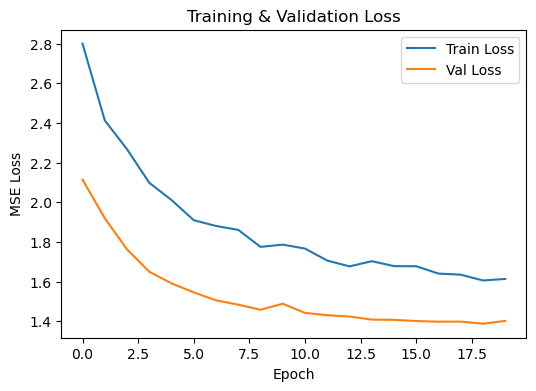


=== Validation Set Performance ===


RMSE      R2  Pearson  Spearman
Validation Set  1.1837  0.3496   0.6015    0.6129

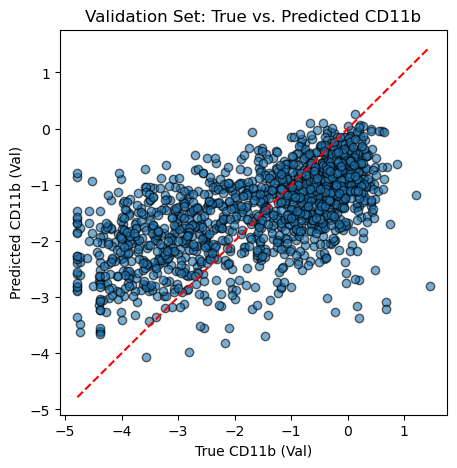


=== Test Set Performance ===


RMSE      R2  Pearson  Spearman
Test Set (A1)  1.5317 -0.1374   0.1707    0.1674

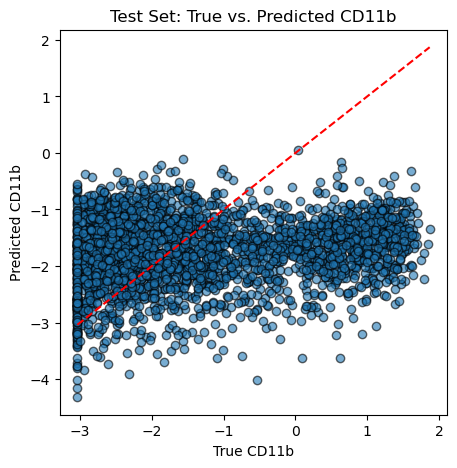

In [ ]:
df = pd.read_csv(csv_file)
# Extract specimen ID and build a unique image identifier
df['specimen_id'] = df['VisSpot'].apply(lambda x: x.split('-')[2])
df['image_id'] = df['specimen_id'] + '_' + df['id'].astype(str)
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_folder, x + ".png"))

mask = df['image_path'].apply(os.path.exists)
df = df[mask].reset_index(drop=True)
# Defining standard transformations 
common_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
# Dataset for loading images and CD11b label
class CD11bDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['image_path']
        label = row['CD11b']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label_tensor = torch.tensor(label, dtype=torch.float32)
        return image, label_tensor

trainval_df = df[df['specimen_id'].isin(['B1','C1','D1'])].copy()
test_df     = df[df['specimen_id'] == 'A1'].copy()

trainval_ds = CD11bDataset(trainval_df, transform=common_transform)
test_ds     = CD11bDataset(test_df,     transform=common_transform)

# Further split trainval_ds into an 80/20 train/val split
train_size  = int(0.8 * len(trainval_ds))
val_size    = len(trainval_ds) - train_size
train_ds, val_ds = random_split(trainval_ds, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train set: {len(train_ds)} | Val set: {len(val_ds)} | Test set: {len(test_ds)}")

resnet = models.resnet18(pretrained=True)
num_features = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 1)
)

for param in resnet.parameters():
    param.requires_grad = False
for param in resnet.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4, weight_decay=1e-4)

num_epochs = 20
best_val_loss = float('inf')
best_model_weights = None

train_loss_history = []
val_loss_history   = []

# Training Loop
for epoch in range(num_epochs):
    epoch_start = time.time()
    
    resnet.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs.view(-1), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_loss_history.append(train_loss)

    # Validation
    resnet.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = resnet(images)
            loss = criterion(outputs.view(-1), labels)
            running_val_loss += loss.item() * images.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    val_loss_history.append(val_loss)

    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train MSE: {train_loss:.4f}, Val MSE: {val_loss:.4f} | "
          f"Epoch time: {epoch_time:.1f}s")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = resnet.state_dict().copy()

resnet.load_state_dict(best_model_weights)

# Plot train vs val loss
plt.figure(figsize=(6,4))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

resnet.eval()
val_y_true_list = []
val_y_pred_list = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet(images)
        val_y_pred_list.append(outputs.view(-1).cpu().numpy())
        val_y_true_list.append(labels.cpu().numpy())

val_y_true = np.concatenate(val_y_true_list, axis=0)
val_y_pred = np.concatenate(val_y_pred_list, axis=0)

val_rmse   = np.sqrt(mean_squared_error(val_y_true, val_y_pred))
val_r2     = r2_score(val_y_true, val_y_pred)
val_pear, _   = pearsonr(val_y_true, val_y_pred)
val_spear, _  = spearmanr(val_y_true, val_y_pred)

val_metrics_df = pd.DataFrame([{
    'RMSE':     round(val_rmse,4),
    'R2':       round(val_r2,4),
    'Pearson':  round(val_pear,4),
    'Spearman': round(val_spear,4)
}], index=['Validation Set'])

print("\n=== Validation Set Performance ===")
display(val_metrics_df)

min_val = np.min(val_y_true)
max_val = np.max(val_y_true)

plt.figure(figsize=(5,5))
plt.scatter(val_y_true, val_y_pred, alpha=0.6, edgecolor='k')
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel("True CD11b (Val)")
plt.ylabel("Predicted CD11b (Val)")
plt.title("Validation Set: True vs. Predicted CD11b")
plt.show()

# Test metrics
test_y_true_list = []
test_y_pred_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet(images)
        test_y_pred_list.append(outputs.view(-1).cpu().numpy())
        test_y_true_list.append(labels.cpu().numpy())

test_y_true = np.concatenate(test_y_true_list, axis=0)
test_y_pred = np.concatenate(test_y_pred_list, axis=0)

test_rmse   = np.sqrt(mean_squared_error(test_y_true, test_y_pred))
test_r2     = r2_score(test_y_true, test_y_pred)
test_pear, _   = pearsonr(test_y_true, test_y_pred)
test_spear, _  = spearmanr(test_y_true, test_y_pred)

test_metrics_df = pd.DataFrame([{
    'RMSE':     round(test_rmse,4),
    'R2':       round(test_r2,4),
    'Pearson':  round(test_pear,4),
    'Spearman': round(test_spear,4)
}], index=['Test Set (A1)'])

print("\n=== Test Set Performance ===")
display(test_metrics_df)

min_val = np.min(test_y_true)
max_val = np.max(test_y_true)
plt.figure(figsize=(5,5))
plt.scatter(test_y_true, test_y_pred, alpha=0.6, edgecolor='k')
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel("True CD11b")
plt.ylabel("Predicted CD11b")
plt.title("Test Set: True vs. Predicted CD11b")
plt.show()

### Custom CNN

The model defines a custom dataset class (CD11bDataset) that transforms each image to a tensor and retrieves the associated CD11b label. The data is split into training, validation, and test sets (with A1 as the test set). A custom CNN (CustomDeepCNN) is then defined, featuring four convolutional blocks (each containing two convolutional layers with batch normalisation, followed by a pooling layer) and two fully connected layers. The code trains this network for 30 epochs, tracking both training and validation loss, and retains the model weights from the epoch with the best validation performance.

Epoch 1: 100%|██████████| 176/176 [00:48<00:00,  3.60it/s]


Epoch 1/30 | Train: 1.0011, Val: 0.8935 | Epoch time: 56.0s


Epoch 2: 100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 2/30 | Train: 0.7333, Val: 0.6797 | Epoch time: 55.1s


Epoch 3: 100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 3/30 | Train: 0.5662, Val: 0.5342 | Epoch time: 55.5s


Epoch 4: 100%|██████████| 176/176 [00:49<00:00,  3.59it/s]


Epoch 4/30 | Train: 0.5230, Val: 0.5290 | Epoch time: 56.2s


Epoch 5: 100%|██████████| 176/176 [00:49<00:00,  3.59it/s]


Epoch 5/30 | Train: 0.5121, Val: 0.5210 | Epoch time: 56.3s


Epoch 6: 100%|██████████| 176/176 [00:49<00:00,  3.58it/s]


Epoch 6/30 | Train: 0.5024, Val: 0.5295 | Epoch time: 56.5s


Epoch 7: 100%|██████████| 176/176 [00:49<00:00,  3.59it/s]


Epoch 7/30 | Train: 0.4899, Val: 0.5126 | Epoch time: 56.4s


Epoch 8: 100%|██████████| 176/176 [00:49<00:00,  3.58it/s]


Epoch 8/30 | Train: 0.4914, Val: 0.5195 | Epoch time: 56.3s


Epoch 9: 100%|██████████| 176/176 [00:49<00:00,  3.56it/s]


Epoch 9/30 | Train: 0.4812, Val: 0.4850 | Epoch time: 56.6s


Epoch 10: 100%|██████████| 176/176 [00:49<00:00,  3.58it/s]


Epoch 10/30 | Train: 0.4771, Val: 0.5019 | Epoch time: 56.3s


Epoch 11: 100%|██████████| 176/176 [00:49<00:00,  3.58it/s]


Epoch 11/30 | Train: 0.4749, Val: 0.4829 | Epoch time: 56.5s


Epoch 12: 100%|██████████| 176/176 [00:49<00:00,  3.58it/s]


Epoch 12/30 | Train: 0.4679, Val: 0.4917 | Epoch time: 56.5s


Epoch 13: 100%|██████████| 176/176 [00:49<00:00,  3.58it/s]


Epoch 13/30 | Train: 0.4634, Val: 0.5015 | Epoch time: 56.5s


Epoch 14: 100%|██████████| 176/176 [00:49<00:00,  3.58it/s]


Epoch 14/30 | Train: 0.4631, Val: 0.5597 | Epoch time: 56.5s


Epoch 15: 100%|██████████| 176/176 [00:49<00:00,  3.57it/s]


Epoch 15/30 | Train: 0.4532, Val: 0.4760 | Epoch time: 56.5s


Epoch 16: 100%|██████████| 176/176 [00:49<00:00,  3.54it/s]


Epoch 16/30 | Train: 0.4489, Val: 0.4688 | Epoch time: 57.3s


Epoch 17: 100%|██████████| 176/176 [00:49<00:00,  3.53it/s]


Epoch 17/30 | Train: 0.4522, Val: 0.4695 | Epoch time: 57.2s


Epoch 18: 100%|██████████| 176/176 [00:49<00:00,  3.57it/s]


Epoch 18/30 | Train: 0.4437, Val: 0.4638 | Epoch time: 56.4s


Epoch 19: 100%|██████████| 176/176 [00:49<00:00,  3.58it/s]


Epoch 19/30 | Train: 0.4478, Val: 0.4687 | Epoch time: 56.4s


Epoch 20: 100%|██████████| 176/176 [00:49<00:00,  3.58it/s]


Epoch 20/30 | Train: 0.4452, Val: 0.5532 | Epoch time: 56.5s


Epoch 21: 100%|██████████| 176/176 [00:50<00:00,  3.50it/s]


Epoch 21/30 | Train: 0.4370, Val: 0.4676 | Epoch time: 57.4s


Epoch 22: 100%|██████████| 176/176 [00:49<00:00,  3.57it/s]


Epoch 22/30 | Train: 0.4333, Val: 0.4698 | Epoch time: 57.3s


Epoch 23: 100%|██████████| 176/176 [00:52<00:00,  3.36it/s]


Epoch 23/30 | Train: 0.4370, Val: 0.4893 | Epoch time: 60.4s


Epoch 24: 100%|██████████| 176/176 [00:51<00:00,  3.43it/s]


Epoch 24/30 | Train: 0.4364, Val: 0.5085 | Epoch time: 58.9s


Epoch 25: 100%|██████████| 176/176 [00:50<00:00,  3.51it/s]


Epoch 25/30 | Train: 0.4276, Val: 0.5227 | Epoch time: 57.7s


Epoch 26: 100%|██████████| 176/176 [00:50<00:00,  3.46it/s]


Epoch 26/30 | Train: 0.4343, Val: 0.4670 | Epoch time: 58.3s


Epoch 27: 100%|██████████| 176/176 [00:51<00:00,  3.41it/s]


Epoch 27/30 | Train: 0.4336, Val: 0.4711 | Epoch time: 58.8s


Epoch 28: 100%|██████████| 176/176 [00:52<00:00,  3.37it/s]


Epoch 28/30 | Train: 0.4259, Val: 0.4773 | Epoch time: 59.9s


Epoch 29: 100%|██████████| 176/176 [00:50<00:00,  3.48it/s]


Epoch 29/30 | Train: 0.4267, Val: 0.4711 | Epoch time: 59.2s


Epoch 30: 100%|██████████| 176/176 [00:49<00:00,  3.56it/s]


Epoch 30/30 | Train: 0.4265, Val: 0.5653 | Epoch time: 56.8s


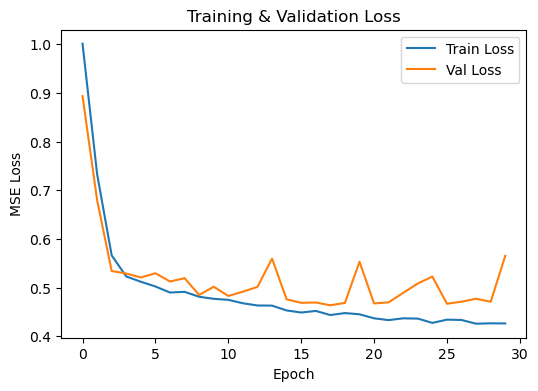


=== Performance Tables ===


RMSE      R2  Pearson  Spearman
Validation Set  1.227  0.3067   0.6661    0.6693

RMSE      R2  Pearson  Spearman
Test Set (A1)  1.6985 -0.3988     0.56    0.5748

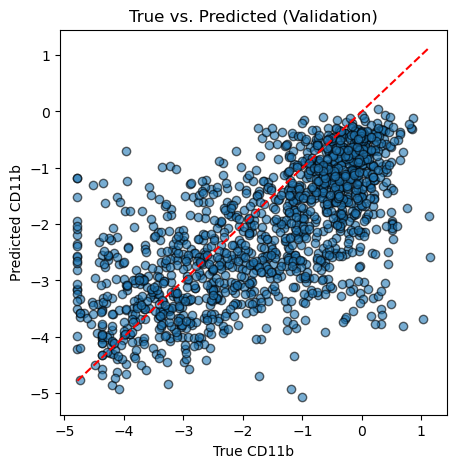

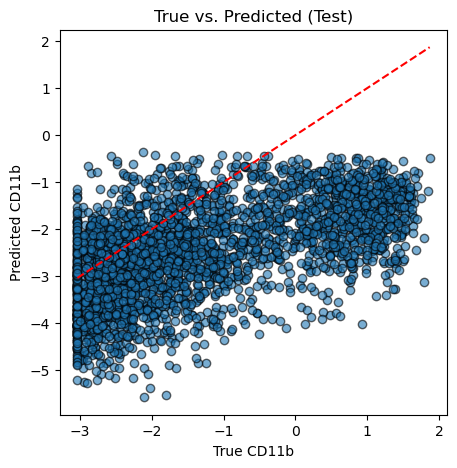

In [ ]:
df = pd.read_csv(csv_file)

# Builds a path to the image file
df['specimen_id'] = df['VisSpot'].apply(lambda x: x.split('-')[2])
df['image_id']    = df['specimen_id'] + '_' + df['id'].astype(str)
df['image_path']  = df['image_id'].apply(lambda x: os.path.join(image_folder, x + ".png"))
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)

common_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
# Dataset for loading images and CD11b label
class CD11bDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        # Apply transformation to image
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row['CD11b'], dtype=torch.float32)
        return image, label

trainval_df = df[df['specimen_id'].isin(['B1','C1','D1'])].copy()
test_df     = df[df['specimen_id'] == 'A1'].copy()

trainval_ds = CD11bDataset(trainval_df, transform=common_transform)
test_ds     = CD11bDataset(test_df,     transform=common_transform)

# Further split trainval_ds into an 80/20 train/val split
train_size  = int(0.8 * len(trainval_ds))
val_size    = len(trainval_ds) - train_size
train_ds, val_ds = random_split(trainval_ds, [train_size, val_size])

# DataLoaders 
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True,num_workers=0,pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size,shuffle=False,num_workers=0,pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size,shuffle=False,num_workers=0,pin_memory=True)

class CustomDeepCNN(nn.Module):
    def __init__(self):
        super(CustomDeepCNN, self).__init__()
        # Block 1 - two conv layers + BN, then a pooling
        self.conv1a = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1a   = nn.BatchNorm2d(32)
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1b   = nn.BatchNorm2d(32)
        # Block 2
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2a   = nn.BatchNorm2d(64)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2b   = nn.BatchNorm2d(64)
        # Block 3
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3a   = nn.BatchNorm2d(128)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3b   = nn.BatchNorm2d(128)
        # Block 4
        self.conv4a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4a   = nn.BatchNorm2d(256)
        self.conv4b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4b   = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2,2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        # Fully connected layers after flattening
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_out = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.0)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool(x)
        # Block 2
        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool(x)
        # Block 3
        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool(x)
        # Block 4
        x = F.relu(self.bn4a(self.conv4a(x)))
        x = F.relu(self.bn4b(self.conv4b(x)))
        x = self.pool(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        # Fully connected layers + dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc_out(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomDeepCNN().to(device)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

num_epochs = 30
best_val_loss = float('inf')
best_model_weights = None

train_loss_history = []
val_loss_history   = []

for epoch in range(num_epochs):
    epoch_start = time.time()

    #Training
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.view(-1), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_loss_history.append(train_loss)

    # Validation 
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            loss  = criterion(preds.view(-1), labels)
            running_val_loss += loss.item() * images.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    val_loss_history.append(val_loss)

    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train: {train_loss:.4f}, Val: {val_loss:.4f} | "
          f"Epoch time: {epoch_time:.1f}s")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict().copy()

model.load_state_dict(best_model_weights)

plt.figure(figsize=(6,4))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

def gather_predictions(loader):
    y_true_list, y_pred_list = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images).view(-1)
            y_pred_list.append(preds.cpu().numpy())
            y_true_list.append(labels.cpu().numpy())
    y_true = np.concatenate(y_true_list, axis=0)
    y_pred = np.concatenate(y_pred_list, axis=0)
    return y_true, y_pred

def compute_regression_metrics(y_true, y_pred):
    rmse   = np.sqrt(mean_squared_error(y_true, y_pred))
    r2val  = r2_score(y_true, y_pred)
    pear, _   = pearsonr(y_true, y_pred)
    spear, _  = spearmanr(y_true, y_pred)
    return rmse, r2val, pear, spear

# Validation
val_y_true, val_y_pred = gather_predictions(val_loader)
val_rmse, val_r2, val_pear, val_spear = compute_regression_metrics(val_y_true, val_y_pred)

val_metrics_df = pd.DataFrame([{
    'RMSE':     round(val_rmse,4),
    'R2':       round(val_r2,4),
    'Pearson':  round(val_pear,4),
    'Spearman': round(val_spear,4)
}], index=['Validation Set'])

# Test
test_y_true, test_y_pred = gather_predictions(test_loader)
test_rmse, test_r2, test_pear, test_spear = compute_regression_metrics(test_y_true, test_y_pred)

test_metrics_df = pd.DataFrame([{
    'RMSE':     round(test_rmse,4),
    'R2':       round(test_r2,4),
    'Pearson':  round(test_pear,4),
    'Spearman': round(test_spear,4)
}], index=['Test Set (A1)'])

print("\n=== Performance Tables ===")
display(val_metrics_df)
display(test_metrics_df)

plt.figure(figsize=(5,5))
plt.scatter(val_y_true, val_y_pred, alpha=0.6, edgecolor='k')
plt.plot([val_y_true.min(), val_y_true.max()],
         [val_y_true.min(), val_y_true.max()], 'r--')
plt.xlabel("True CD11b")
plt.ylabel("Predicted CD11b")
plt.title("True vs. Predicted (Validation)")
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(test_y_true, test_y_pred, alpha=0.6, edgecolor='k')
plt.plot([test_y_true.min(), test_y_true.max()],
         [test_y_true.min(), test_y_true.max()], 'r--')
plt.xlabel("True CD11b")
plt.ylabel("Predicted CD11b")
plt.title("True vs. Predicted (Test)")
plt.show()

This code below implements a leave-one-specimen-out cross-validation approach for predicting multiple protein expression levels using the custom CNN made previously. After evaluation on the held-out specimen, the process repeats for each specimen, and the code computes and displays mean ± standard deviation of RMSE, Pearson, Spearman, and R² across all folds.

Specimen A1 Epoch 8: 100%|██████████| 220/220 [01:04<00:00,  3.43it/s]


LOOCV Fold (Specimen=A1) => RMSE=0.923, Pearson=0.761, Spearman=0.774, R2=0.010


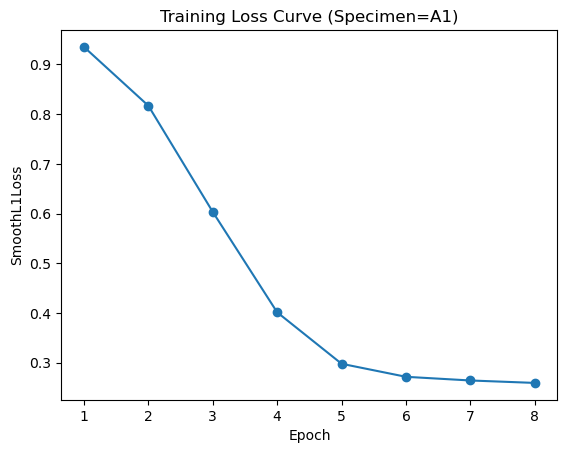

Specimen B1 Epoch 8: 100%|██████████| 275/275 [01:21<00:00,  3.38it/s]


LOOCV Fold (Specimen=B1) => RMSE=0.832, Pearson=0.792, Spearman=0.796, R2=-0.041


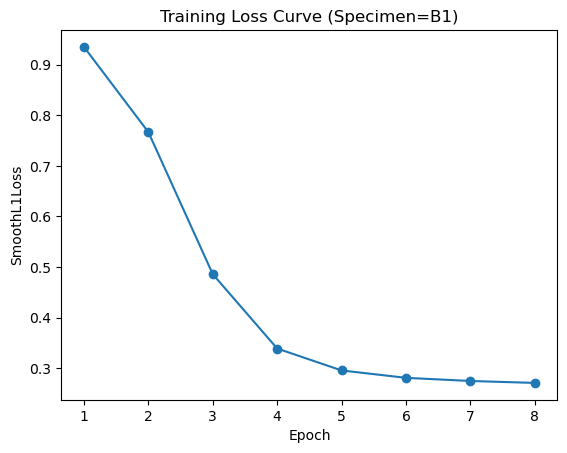

Specimen C1 Epoch 8: 100%|██████████| 181/181 [00:52<00:00,  3.43it/s]


LOOCV Fold (Specimen=C1) => RMSE=0.925, Pearson=0.755, Spearman=0.766, R2=0.008


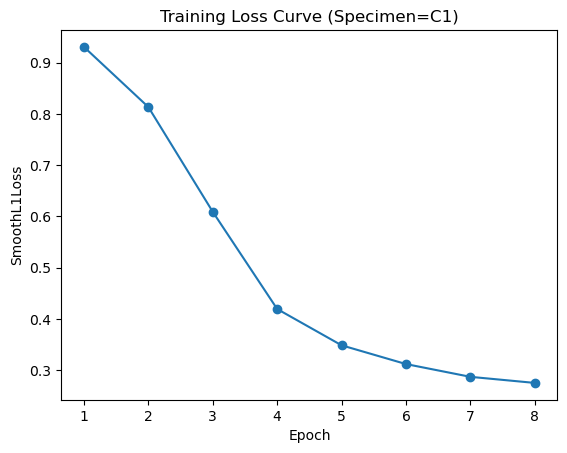

Specimen D1 Epoch 8: 100%|██████████| 256/256 [01:13<00:00,  3.48it/s]


LOOCV Fold (Specimen=D1) => RMSE=0.921, Pearson=0.757, Spearman=0.781, R2=0.053


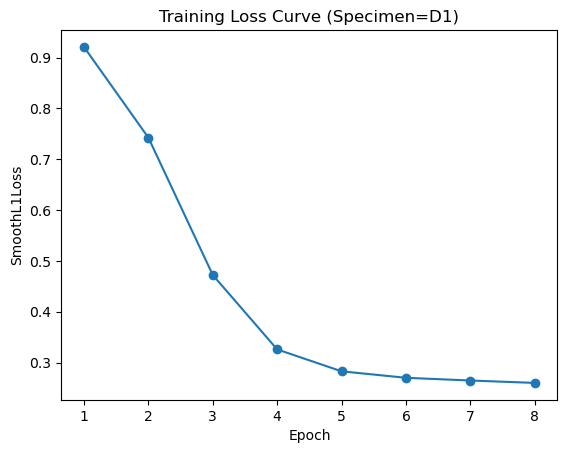


LOOCV Performance (Mean ± Std) across all specimens:


RMSE        Pearson       Spearman            R^2
LOOCV Summary  0.900 ± 0.039  0.766 ± 0.015  0.779 ± 0.011  0.007 ± 0.033

In [ ]:
protein_names = [
 'SMAa', 'CD11b','CD44','CD31','CDK4','YKL40','CD11c','HIF1a','CD24','TMEM119',
 'OLIG2','GFAP','VISTA','IBA1','CD206','PTEN','NESTIN','TCIRG1',
 'CD74','MET','P2RY12','CD163','S100B','cMYC','pERK','EGFR',
 'SOX2','HLADR','PDGFRa','MCT4','DNA1','DNA3','MHCI','CD68',
 'CD14','KI67','CD16','SOX10'
]

df = pd.read_csv(csv_file)
df['specimen_id'] = df['VisSpot'].apply(lambda x: x.split('-')[2])
df['image_id']    = df['specimen_id'] + '_' + df['id'].astype(str)
df['image_path']  = df['image_id'].apply(lambda x: os.path.join(image_folder, x + ".png"))
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)

# Drop rows with NaN in any protein columns
df = df.dropna(subset=protein_names).reset_index(drop=True)

common_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

class MultiProteinDataset(Dataset):
    """
    Returns (image, target_tensor, specimen_id)
    """
    def __init__(self, df, protein_names, transform=None):
        self.df = df.reset_index(drop=True)
        self.protein_names = protein_names
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['image_path']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        targets = np.array([row[p] for p in self.protein_names], dtype=np.float32)
        target_tensor = torch.tensor(targets)  # shape [n_proteins]

        specimen_id = row['specimen_id']
        return image, target_tensor, specimen_id

dataset = MultiProteinDataset(df, protein_names, transform=common_transform)

class CustomDeepCNN(nn.Module):
    def __init__(self, n_outputs):
        super(CustomDeepCNN, self).__init__()
        # ----- Block 1 -----
        self.conv1a = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1a   = nn.BatchNorm2d(32)
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1b   = nn.BatchNorm2d(32)
        
        # ----- Block 2 -----
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2a   = nn.BatchNorm2d(64)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2b   = nn.BatchNorm2d(64)
        
        # ----- Block 3 -----
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3a   = nn.BatchNorm2d(128)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3b   = nn.BatchNorm2d(128)
        
        # ----- Block 4 -----
        self.conv4a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4a   = nn.BatchNorm2d(256)
        self.conv4b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4b   = nn.BatchNorm2d(256)

        self.pool    = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.fc1    = nn.Linear(256, 128)
        self.fc2    = nn.Linear(128, 64)
        self.fc_out = nn.Linear(64, n_outputs)
        self.dropout= nn.Dropout(p=0.0)

    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn4a(self.conv4a(x)))
        x = F.relu(self.bn4b(self.conv4b(x)))
        x = self.pool(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc_out(x)

specimen_ids = sorted(df['specimen_id'].unique())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_proteins = len(protein_names)

fold_metrics = []
all_preds_all_folds = []
all_true_all_folds  = []

for specimen in specimen_ids:
    test_indices  = [i for i in range(len(dataset)) if dataset.df.loc[i,'specimen_id'] == specimen]
    train_indices = [i for i in range(len(dataset)) if dataset.df.loc[i,'specimen_id'] != specimen]

    train_loader = DataLoader(Subset(dataset, train_indices), batch_size=32, shuffle=True)
    test_loader  = DataLoader(Subset(dataset, test_indices),  batch_size=32, shuffle=False)

    model = CustomDeepCNN(n_outputs=n_proteins).to(device)
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

    num_epochs = 8
    train_loss_history = []

    # Train + store train loss
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, targets, _ in tqdm(train_loader, desc=f"Specimen {specimen} Epoch {epoch+1}"):
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_loss)

    # Evaluate
    model.eval()
    all_preds = []
    all_true  = []
    with torch.no_grad():
        for images, targets, _ in test_loader:
            images = images.to(device)
            preds  = model(images)
            all_preds.append(preds.cpu().numpy())
            all_true.append(targets.numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_true  = np.concatenate(all_true,  axis=0)

    rmse     = np.sqrt(np.mean((all_preds - all_true)**2))
    pearson  = pearsonr(all_true.flatten(), all_preds.flatten())[0]
    spearman = spearmanr(all_true.flatten(), all_preds.flatten())[0]
    r2       = r2_score(all_true, all_preds, multioutput='uniform_average')

    fold_metrics.append({
        'Specimen': specimen,
        'RMSE': rmse,
        'Pearson': pearson,
        'Spearman': spearman,
        'R2': r2
    })
    all_preds_all_folds.append(all_preds)
    all_true_all_folds.append(all_true)

    
    print(f"LOOCV Fold (Specimen={specimen}) => "
          f"RMSE={rmse:.3f}, Pearson={pearson:.3f}, Spearman={spearman:.3f}, R2={r2:.3f}")

    # training loss curve for fold
    plt.figure()
    plt.plot(range(1, len(train_loss_history)+1), train_loss_history, marker='o')
    plt.title(f"Training Loss Curve (Specimen={specimen})")
    plt.xlabel("Epoch")
    plt.ylabel("SmoothL1Loss")
    plt.show()

# Summarise across folds
rmse_vals     = [fm['RMSE'] for fm in fold_metrics]
pearson_vals  = [fm['Pearson'] for fm in fold_metrics]
spearman_vals = [fm['Spearman'] for fm in fold_metrics]
r2_vals       = [fm['R2'] for fm in fold_metrics]

rmse_mean, rmse_std     = np.mean(rmse_vals),     np.std(rmse_vals)
pearson_mean, pearson_std  = np.mean(pearson_vals),  np.std(pearson_vals)
spearman_mean, spearman_std = np.mean(spearman_vals), np.std(spearman_vals)
r2_mean, r2_std         = np.mean(r2_vals),       np.std(r2_vals)

summary_df = pd.DataFrame([{
    'RMSE':      f"{rmse_mean:.3f} ± {rmse_std:.3f}",
    'Pearson':   f"{pearson_mean:.3f} ± {pearson_std:.3f}",
    'Spearman':  f"{spearman_mean:.3f} ± {spearman_std:.3f}",
    'R^2':       f"{r2_mean:.3f} ± {r2_std:.3f}"
}], index=['LOOCV Summary'])

print("\nLOOCV Performance (Mean ± Std) across all specimens:")
display(summary_df)

From the data below, the four LOOCV scatter plots (A1, B1, C1, D1), the model’s predictions cluster within a narrow band (roughly -2 to 0) while the true expression spans a much broader range (around -12 to +5). This pattern indicates systematic underestimation for both highly negative and highly positive values, causing many points to deviate significantly from the ideal diagonal line. Consistently low Spearman correlations (no protein exceeds 0.7) confirm that the model is capturing only a moderate rank-order relationship at best, with proteins like NESTIN, cMYC, and CDK4 topping out around 0.5. Overall, these findings suggest the current CNN underfits expression extremes and struggles to leverage subtle cues distinguishing high vs. low levels. 

**-** Incorporating location data and additional metadata can greatly enhance predictive accuracy for protein expression, especially when some proteins exhibit strong spatial gradients. By feeding normalized coordinates (X, Y) into the model alongside the CNN’s learned image features—or by employing graph-based methods that treat spatially adjacent spots as neighbors—you allow the network to capture global tissue trends that local patch morphology alone may not reveal. These strategies are particularly helpful for proteins whose expression correlates strongly with position and can push overall correlations higher by resolving subtle but systematic spatial patterns.

**-** To ensure the model truly predicts CD11b rather than leveraging correlated proteins, you can examine partial correlations—checking whether predicted vs. true CD11b remains correlated when controlling for other targets. If correlations collapse after removing certain proteins from the training target or input, it indicates the model was indirectly predicting CD11b via those correlated proteins. This poses interpretability and generalisation risks, as the model may fail when those correlated proteins behave differently in new data. To address this, regularly validate CD11b-specific signals and verify biologically through targeted stains or experiments. Such measures increase confidence that the model genuinely captures CD11b expressions.




Per-Protein Average Spearman across folds:
  SMAa    : -0.037
  CD11b   : 0.337
  CD44    : 0.022
  CD31    : 0.036
  CDK4    : 0.508
  YKL40   : 0.392
  CD11c   : 0.198
  HIF1a   : 0.116
  CD24    : -0.042
  TMEM119 : 0.426
  OLIG2   : 0.107
  GFAP    : 0.099
  VISTA   : 0.144
  IBA1    : 0.146
  CD206   : 0.293
  PTEN    : 0.331
  NESTIN  : 0.493
  TCIRG1  : 0.338
  CD74    : -0.080
  MET     : 0.323
  P2RY12  : 0.125
  CD163   : 0.198
  S100B   : 0.150
  cMYC    : 0.493
  pERK    : 0.350
  EGFR    : 0.191
  SOX2    : 0.347
  HLADR   : 0.093
  PDGFRa  : 0.489
  MCT4    : 0.360
  DNA1    : 0.129
  DNA3    : 0.112
  MHCI    : 0.252
  CD68    : 0.161
  CD14    : 0.134
  KI67    : 0.189
  CD16    : 0.231
  SOX10   : 0.135

Number of proteins with avg Spearman > 0.7: 0/38


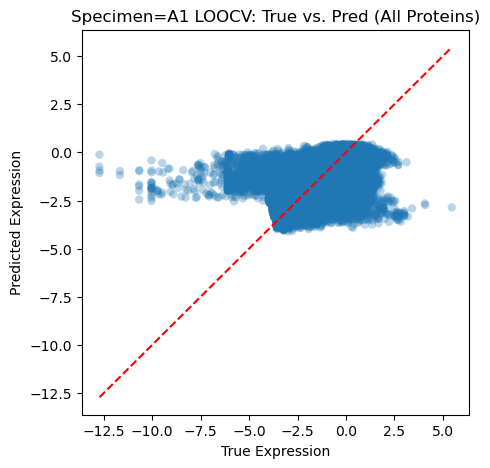

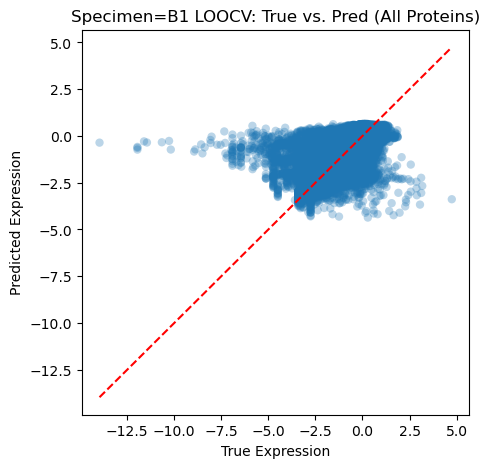

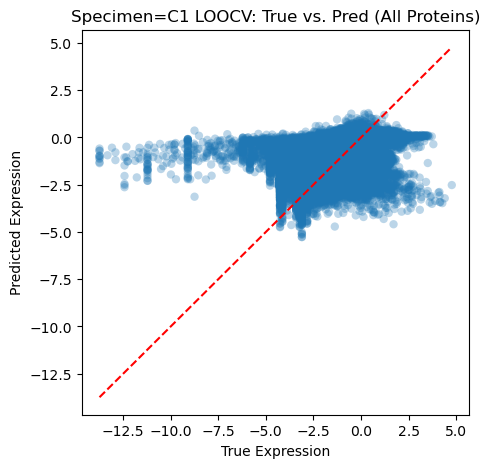

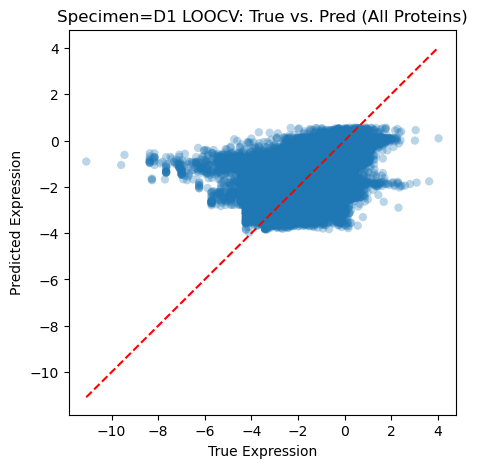

In [ ]:
protein_spearmans_folds = []  # shape [n_folds, n_proteins]
for fold_i, specimen in enumerate(specimen_ids):
    fold_preds = all_preds_all_folds[fold_i]  # [N_test, n_proteins]
    fold_true  = all_true_all_folds[fold_i]   # [N_test, n_proteins]

    fold_spear = []
    for j in range(n_proteins):
        rho = spearmanr(fold_true[:, j], fold_preds[:, j])[0]
        fold_spear.append(rho)
    protein_spearmans_folds.append(fold_spear)

protein_spearmans_folds = np.array(protein_spearmans_folds)  # shape [n_folds, n_proteins]
avg_spear_protein = np.nanmean(protein_spearmans_folds, axis=0)

print("\nPer-Protein Average Spearman across folds:")
for prot, rho_avg in zip(protein_names, avg_spear_protein):
    print(f"  {prot:8s}: {rho_avg:.3f}")

count_high = np.sum(avg_spear_protein > 0.7)
print(f"\nNumber of proteins with avg Spearman > 0.7: {count_high}/{len(protein_names)}")

for fold_i, specimen in enumerate(specimen_ids):
    preds = all_preds_all_folds[fold_i]
    true  = all_true_all_folds[fold_i]

    plt.figure(figsize=(5,5))
    plt.scatter(true.flatten(), preds.flatten(), alpha=0.3, edgecolor='none')
    plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--')
    plt.title(f"Specimen={specimen} LOOCV: True vs. Pred (All Proteins)")
    plt.xlabel("True Expression")
    plt.ylabel("Predicted Expression")
    plt.show()